In [1]:
import math
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import torchvision
from ema_pytorch import EMA
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt


In [2]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.reshape(-1, logits.size(-1)), targets.reshape(-1), ignore_index=-1)
            # loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [3]:
@dataclass
class GPTConfig:
    block_size: int = 64  # maximum sequence length
    vocab_size: int = 64 + 10
    n_layer: int = 6  # 12
    n_head: int = 6  # 12
    n_embd: int = 768 // 8
    dropout: float = 0.1
    bias: bool = (
        False  # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster
    )

In [4]:
model = GPT(GPTConfig()).to("mps")
num_train_steps = 0

number of parameters: 0.67M


In [5]:
dataset = torch.load("projects/custom/vq-vae/idxs/train_indexed.pt")
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)


In [6]:
model(torch.randn(32, 1, device="mps").long())[0].shape


torch.Size([32, 1, 74])

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = torch.nn.CrossEntropyLoss()


In [8]:
ema = EMA(model, beta=0.999, update_after_step=100, update_every=1)


In [9]:
def generate():
    model.eval()
    with torch.no_grad():
        generated = model.generate(
            torch.arange(10, device="mps").repeat(4).view(40, 1) + 64,
            64,
            temperature=1.0,
        )[:, -64:]

        # Get embeded values from generated idx
        quantized_x = (
            F.embedding(
                generated.view(40, *generated.shape[1:]),
                vqvae.vq.e_i_ts.transpose(0, 1),
            )
            .permute(0, 2, 1)
            .view(40, 4, 8, 8)
        )

        # Get reconstructed values
        x_recon = vqvae.decoder(quantized_x)

    grid = torchvision.utils.make_grid(x_recon, nrow=20, normalize=True).cpu()

    plt.figure(figsize=(20, 20))
    plt.imshow(grid.permute(1, 2, 0).detach().numpy())
    plt.axis("off")
    plt.show()

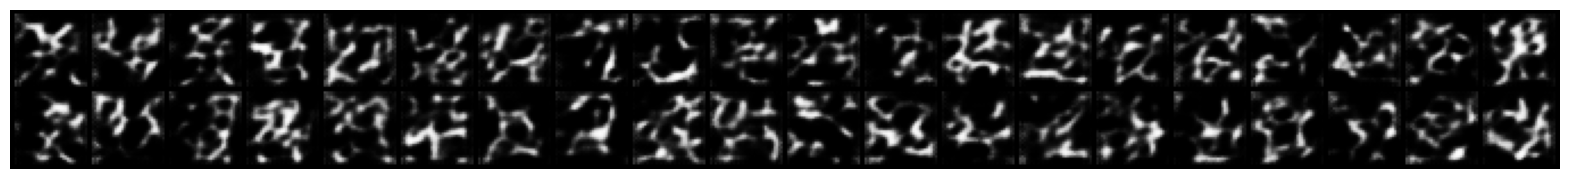

In [12]:
generate()


training loss:   1%|          | 1/100 [04:02<1:51:43, 67.72s/batch, est_acc=0.123, loss=2.09, num_train_steps=4999]

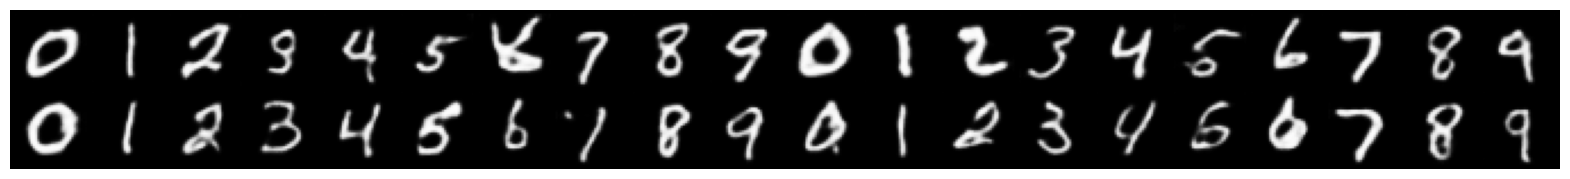

training loss:   3%|▎         | 3/100 [09:39<4:51:22, 180.24s/batch, est_acc=0.13, loss=2.04, num_train_steps=5999] 

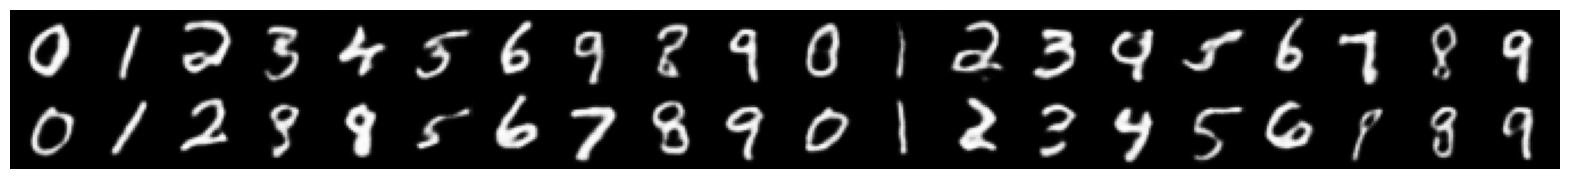

training loss:   5%|▌         | 5/100 [12:04<2:57:01, 111.81s/batch, est_acc=0.129, loss=2.05, num_train_steps=6999]

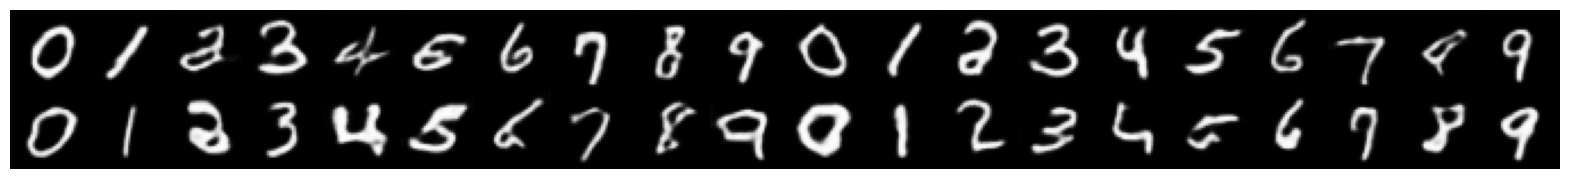

batch:  92%|█████████▏| 430/469 [01:02<00:05,  6.86it/s]1.81s/batch, est_acc=0.148, loss=1.91, num_train_steps=7209]


KeyboardInterrupt: 

In [14]:
# Train
pbar = tqdm.trange(100, desc="training loss", unit="batch", leave=False)
for epoch in pbar:
    model.train()
    for i, (x, y) in tqdm.tqdm(enumerate(loader), total=len(loader), desc="batch", leave=True):
        x = x.to("mps")
        y = y.to("mps").view(-1, 1) + 64

        x = torch.cat([y, x], dim=1)
        
        optimizer.zero_grad()

        inputs = x[:, :-1]
        targets = x[:, 1:]

        logits, loss = model(inputs, targets)

        loss.backward()
        optimizer.step()

        ema.update()

        num_train_steps += 1

        if num_train_steps % 1000 == 0:
            generate()

        pbar.set_postfix(loss=loss.item(), est_acc=torch.exp(-loss).item(), num_train_steps=num_train_steps)

In [ ]:
torch.save(model.state_dict(), "projects/paper-implementations/sequence-generation/4-transformer/gpt2-mnist.pth")

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import tqdm as tqdm
import lightning.pytorch as pl
from pytorch_lightning.loggers import WandbLogger
import wandb
from torchmetrics.image.fid import FrechetInceptionDistance


class ResidualStack(nn.Module):
    def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        layers = []
        for i in range(num_residual_layers):
            layers.append(
                nn.Sequential(
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_hiddens,
                        out_channels=num_residual_hiddens,
                        kernel_size=3,
                        padding=1,
                    ),
                    nn.ReLU(),
                    nn.Conv2d(
                        in_channels=num_residual_hiddens,
                        out_channels=num_hiddens,
                        kernel_size=1,
                    ),
                )
            )

        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        h = x
        for layer in self.layers:
            h = h + layer(h)

        # ResNet V1-style.
        return torch.relu(h)


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        # The last ReLU from the Sonnet example is omitted because ResidualStack starts
        # off with a ReLU.
        conv = nn.Sequential()
        for downsampling_layer in range(num_downsampling_layers):
            if downsampling_layer == 0:
                out_channels = num_hiddens // 2
            elif downsampling_layer == 1:
                (in_channels, out_channels) = (num_hiddens // 2, num_hiddens)

            else:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            conv.add_module(
                f"down{downsampling_layer}",
                nn.Conv2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            conv.add_module(f"relu{downsampling_layer}", nn.ReLU())

        conv.add_module(
            "final_conv",
            nn.Conv2d(
                in_channels=num_hiddens,
                out_channels=num_hiddens,
                kernel_size=3,
                padding=1,
            ),
        )
        self.conv = conv
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )

    def forward(self, x):
        h = self.conv(x)
        return self.residual_stack(h)


class Decoder(nn.Module):
    def __init__(
        self,
        embedding_dim,
        num_hiddens,
        num_upsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        out,
    ):
        super().__init__()
        # See Section 4.1 of "Neural Discrete Representation Learning".
        self.conv = nn.Conv2d(
            in_channels=embedding_dim,
            out_channels=num_hiddens,
            kernel_size=3,
            padding=1,
        )
        self.residual_stack = ResidualStack(
            num_hiddens, num_residual_layers, num_residual_hiddens
        )
        upconv = nn.Sequential()
        for upsampling_layer in range(num_upsampling_layers):
            if upsampling_layer < num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens)

            elif upsampling_layer == num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens, num_hiddens // 2)

            elif upsampling_layer > num_upsampling_layers - 2:
                (in_channels, out_channels) = (num_hiddens // 2, out)
            else:
                raise ValueError(
                    f"Invalid upsampling layer: {upsampling_layer}. In Encoder."
                )

            upconv.add_module(
                f"up{upsampling_layer}",
                nn.ConvTranspose2d(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    kernel_size=4,
                    stride=2,
                    padding=1,
                ),
            )
            if upsampling_layer < num_upsampling_layers - 1:
                upconv.add_module(f"relu{upsampling_layer}", nn.ReLU())

        self.upconv = upconv

    def forward(self, x):
        h = self.conv(x)
        h = self.residual_stack(h)
        x_recon = self.upconv(h)
        return F.sigmoid(x_recon)


class SonnetExponentialMovingAverage(nn.Module):
    # See: https://github.com/deepmind/sonnet/blob/5cbfdc356962d9b6198d5b63f0826a80acfdf35b/sonnet/src/moving_averages.py#L25.
    # They do *not* use the exponential moving average updates described in Appendix A.1
    # of "Neural Discrete Representation Learning".
    def __init__(self, decay, shape):
        super().__init__()
        self.decay = decay
        self.counter = 0
        self.register_buffer("hidden", torch.zeros(*shape))
        self.register_buffer("average", torch.zeros(*shape))

    def update(self, value):
        self.counter += 1
        with torch.no_grad():
            self.hidden -= (self.hidden - value) * (1 - self.decay)
            self.average = self.hidden / (1 - self.decay**self.counter)

    def __call__(self, value):
        self.update(value)
        return self.average


class VectorQuantizer(nn.Module):
    def __init__(self, embedding_dim, num_embeddings, use_ema, decay, epsilon):
        super().__init__()
        # See Section 3 of "Neural Discrete Representation Learning" and:
        # https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L142.

        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.use_ema = use_ema
        # Weight for the exponential moving average.
        self.decay = decay
        # Small constant to avoid numerical instability in embedding updates.
        self.epsilon = epsilon

        # Dictionary embeddings.
        limit = 3**0.5
        e_i_ts = torch.FloatTensor(embedding_dim, num_embeddings).uniform_(
            -limit, limit
        )
        if use_ema:
            self.register_buffer("e_i_ts", e_i_ts)
        else:
            self.register_parameter("e_i_ts", nn.Parameter(e_i_ts))

        # Exponential moving average of the cluster counts.
        self.N_i_ts = SonnetExponentialMovingAverage(decay, (num_embeddings,))
        # Exponential moving average of the embeddings.
        self.m_i_ts = SonnetExponentialMovingAverage(decay, e_i_ts.shape)

    def forward(self, x):
        flat_x = x.permute(0, 2, 3, 1).reshape(-1, self.embedding_dim)
        distances = (
            (flat_x**2).sum(1, keepdim=True)
            - 2 * flat_x @ self.e_i_ts
            + (self.e_i_ts**2).sum(0, keepdim=True)
        )
        encoding_indices = distances.argmin(1)
        quantized_x = F.embedding(
            encoding_indices.view(x.shape[0], *x.shape[2:]), self.e_i_ts.transpose(0, 1)
        ).permute(0, 3, 1, 2)

        # See second term of Equation (3).
        if not self.use_ema:
            dictionary_loss = ((x.detach() - quantized_x) ** 2).mean()
        else:
            dictionary_loss = None

        # See third term of Equation (3).
        commitment_loss = ((x - quantized_x.detach()) ** 2).mean()
        # Straight-through gradient. See Section 3.2.
        quantized_x = x + (quantized_x - x).detach()

        if self.use_ema and self.training:
            with torch.no_grad():
                # See Appendix A.1 of "Neural Discrete Representation Learning".

                # Cluster counts.
                encoding_one_hots = F.one_hot(
                    encoding_indices, self.num_embeddings
                ).type(flat_x.dtype)
                n_i_ts = encoding_one_hots.sum(0)
                # Updated exponential moving average of the cluster counts.
                # See Equation (6).
                self.N_i_ts(n_i_ts)

                # Exponential moving average of the embeddings. See Equation (7).
                embed_sums = flat_x.transpose(0, 1) @ encoding_one_hots
                self.m_i_ts(embed_sums)

                # This is kind of weird.
                # Compare: https://github.com/deepmind/sonnet/blob/v2/sonnet/src/nets/vqvae.py#L270
                # and Equation (8).
                N_i_ts_sum = self.N_i_ts.average.sum()
                N_i_ts_stable = (
                    (self.N_i_ts.average + self.epsilon)
                    / (N_i_ts_sum + self.num_embeddings * self.epsilon)
                    * N_i_ts_sum
                )
                self.e_i_ts = self.m_i_ts.average / N_i_ts_stable.unsqueeze(0)

        return (
            quantized_x,
            dictionary_loss,
            commitment_loss,
            encoding_indices.view(x.shape[0], -1),
        )


class VQVAE(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        num_hiddens,
        num_downsampling_layers,
        num_residual_layers,
        num_residual_hiddens,
        embedding_dim,
        num_embeddings,
        use_ema,
        decay,
        epsilon,
    ):
        super().__init__()
        self.encoder = Encoder(
            in_channels,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
        )
        self.pre_vq_conv = nn.Conv2d(
            in_channels=num_hiddens, out_channels=embedding_dim, kernel_size=1
        )
        self.vq = VectorQuantizer(
            embedding_dim, num_embeddings, use_ema, decay, epsilon
        )
        self.decoder = Decoder(
            embedding_dim,
            num_hiddens,
            num_downsampling_layers,
            num_residual_layers,
            num_residual_hiddens,
            out_channels,
        )

    def quantize(self, x):
        z = self.pre_vq_conv(self.encoder(x))
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = self.vq(z)
        return (z_quantized, dictionary_loss, commitment_loss, encoding_indices)

    def forward(self, x):
        (z_quantized, dictionary_loss, commitment_loss, encoding_indices) = (
            self.quantize(x)
        )
        x_recon = self.decoder(z_quantized)
        return {
            "dictionary_loss": dictionary_loss,
            "commitment_loss": commitment_loss,
            "x_recon": x_recon,
            "encoding_indices": encoding_indices,
        }


class VQVAE_Trainer(pl.LightningModule):
    def __init__(
        self,
        sample_size=128,
        in_channels=3,
        out_channels=3,
        num_hiddens=64,
        num_downsampling_layers=2,
        num_residual_layers=4,
        num_residual_hiddens=128,
        embedding_dim=64,  # 32, 64, 128, 256
        num_embeddings=2048,  # 256, 512, 1024, 2048
        use_ema=True,
        decay=0.99,
        epsilon=1e-5,
        beta=0.25,
        lr=2e-4,
        weight_decay=0.0,
        fid_features=2048,
        batch_size=64,  # 128
        dataset="celeba_hq",
    ):
        super(VQVAE_Trainer, self).__init__()
        self.model = VQVAE(
            in_channels=in_channels,
            out_channels=out_channels,
            num_hiddens=num_hiddens,
            num_downsampling_layers=num_downsampling_layers,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens,
            embedding_dim=embedding_dim,
            num_embeddings=num_embeddings,
            use_ema=use_ema,
            decay=decay,
            epsilon=epsilon,
        )

        self.beta = beta
        self.save_hyperparameters()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)
        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("train_dictionary_loss", out["dictionary_loss"])

        self.log("train_loss", loss)
        self.log("train_recon_error", recon_error)
        self.log("train_commitment_loss", out["commitment_loss"])

        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        recon_error = F.mse_loss(out["x_recon"], x)

        loss = recon_error + self.beta * out["commitment_loss"]

        if out["dictionary_loss"] is not None:
            loss += out["dictionary_loss"]
            self.log("val_dictionary_loss", out["dictionary_loss"])

        self.log("val_loss", loss)
        self.log("val_recon_error", recon_error)
        self.log("val_commitment_loss", out["commitment_loss"])

        if batch_idx == 0:
            if self.global_step == 0 and batch_idx == 0:
                self.logger.experiment.log(
                    {
                        "original": wandb.Image(
                            torchvision.utils.make_grid(x[:64], nrow=8),
                            caption="Real Image",
                        )
                    }
                )

            self.logger.experiment.log(
                {
                    "reconstructed": wandb.Image(
                        torchvision.utils.make_grid(out["x_recon"][:64], nrow=8),
                        caption=f"Step {self.global_step}",
                    )
                }
            )

    def on_test_start(self):
        self.fid = FrechetInceptionDistance(self.hparams.fid_features).cpu()

    def test_step(self, batch, batch_idx):
        x, _ = batch

        out = self.model(x)

        # Resize to 299x299
        x = F.interpolate(x, size=299)
        x_hat = F.interpolate(out["x_recon"], size=299)

        if x.shape[1] == 1:
            x = x.repeat(1, 3, 1, 1)
            x_hat = x_hat.repeat(1, 3, 1, 1)

        # Convert to uint8
        x = (x * 255).to(torch.uint8).cpu()
        x_hat = (x_hat * 255).to(torch.uint8).cpu()

        # Compute FID
        self.fid.update(x, real=True)
        self.fid.update(x_hat, real=False)

        fid_score = self.fid.compute()
        self.log("fid_score", fid_score)

    def configure_optimizers(self):
        return optim.Adam(
            self.model.parameters(),
            lr=self.hparams.lr,
            amsgrad=True,
            weight_decay=self.hparams.weight_decay,
        )

    def train_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    (
                        torchvision.transforms.Grayscale()
                        if self.hparams.in_channels == 1
                        else torchvision.transforms.Lambda(lambda x: x)
                    ),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=True, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/train", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            shuffle=True,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def val_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )

    def test_dataloader(self):
        if self.hparams.dataset == "mnist":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.MNIST(
                root="data/mnist", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "cifar10":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.CIFAR10(
                root="data/cifar10", train=False, transform=transform, download=True
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 16))

        elif self.hparams.dataset == "celeba_hq":
            transform = torchvision.transforms.Compose(
                [
                    torchvision.transforms.Resize(self.hparams.sample_size),
                    torchvision.transforms.ToTensor(),
                ]
            )
            dataset = torchvision.datasets.ImageFolder(
                "data/celeba_hq/val", transform=transform
            )
            # Return first 1/4
            dataset = torch.utils.data.Subset(dataset, range(len(dataset) // 4))

        else:
            raise ValueError(f"Unknown dataset: {self.hparams.dataset}")

        return torch.utils.data.DataLoader(
            dataset,
            batch_size=self.hparams.batch_size,
            num_workers=4,
            pin_memory=True,
            persistent_workers=True,
        )


In [11]:
# load from checkpoint
vqvae = VQVAE_Trainer.load_from_checkpoint("vqvae/logs/vq-vae/mnist-32/checkpoints/epoch=10-step=10000.ckpt")
vqvae = vqvae.model.to("mps")
vqvae.eval()

VQVAE(
  (encoder): Encoder(
    (conv): Sequential(
      (down0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu0): ReLU()
      (down1): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (relu1): ReLU()
      (final_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (residual_stack): ResidualStack(
      (layers): ModuleList(
        (0-1): 2 x Sequential(
          (0): ReLU()
          (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (2): ReLU()
          (3): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1))
        )
      )
    )
  )
  (pre_vq_conv): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
  (vq): VectorQuantizer(
    (N_i_ts): SonnetExponentialMovingAverage()
    (m_i_ts): SonnetExponentialMovingAverage()
  )
  (decoder): Decoder(
    (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (residual_stack): ResidualStack(
      (la